# Target :
# a.) Add a GAP layer
# b.) Add data augmentation 
# c.) Experiment with Learning Rate (LR)

# Results :
# a.) Paramteres : 9.9k

# --------------------------After GAP layer------------------------------------------

# a.) Best train accuracy : 99.47
# b.) Best test accuracy :   99.43 (once above 99.4)

# -------------------- After GAP and data augmentation----------------------

# a.) Best train accuracy : 99.19
# b.) Best test accuracy :   99.41 (3 times above 99.4)

# -----------After GAP , data augmentation and LR experiments-------

# a.) Best train accuracy : 99.20
# b.) Best test accuracy :   99.48 (6 times >= 99.4 out of last 9 epochs )

# Analysis : 
# a.) All factors contribute to increase test accuracy
# b.) data augmentation of random rotation applied 
# b.) LR scheduler is used to fine tune the LR 

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     #transforms.Resize((28, 28)),
                                     #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                     transforms.RandomRotation((-7.0, 7.0)),
                                     #transforms.RandomGrayscale(p=0.01),        
                                     #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=16, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
import torch.nn.functional as F
dropout_value = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(11),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(19),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        #self.convblock8 = nn.Sequential(
            #nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        #self.dropout = nn.Dropout(dropout_value)
        
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            #nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        #x = self.convblock8(x)
        #x = x.view(-1, 10)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
       BatchNorm2d-3           [-1, 11, 26, 26]              22
           Dropout-4           [-1, 11, 26, 26]               0
            Conv2d-5           [-1, 19, 24, 24]           1,881
              ReLU-6           [-1, 19, 24, 24]               0
       BatchNorm2d-7           [-1, 19, 24, 24]              38
           Dropout-8           [-1, 19, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             190
      BatchNorm2d-10           [-1, 10, 24, 24]              20
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,350
             ReLU-13           [-1, 15, 10, 10]               0
      BatchNorm2d-14           [-1

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.0002)

#learning_rate = 0.01
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0338413268327713 Batch_id=937 Accuracy=95.52: 100%|████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 110.16it/s]



Test set: Average loss: 0.0514, Accuracy: 9879/10000 (98.79%)

EPOCH: 1


Loss=0.10251466184854507 Batch_id=937 Accuracy=98.02: 100%|███████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 102.97it/s]



Test set: Average loss: 0.0349, Accuracy: 9922/10000 (99.22%)

EPOCH: 2


Loss=0.023006074130535126 Batch_id=937 Accuracy=98.30: 100%|██████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 112.23it/s]



Test set: Average loss: 0.0312, Accuracy: 9909/10000 (99.09%)

EPOCH: 3


Loss=0.038156285881996155 Batch_id=937 Accuracy=98.56: 100%|██████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 101.75it/s]



Test set: Average loss: 0.0280, Accuracy: 9925/10000 (99.25%)

EPOCH: 4


Loss=0.06289897859096527 Batch_id=937 Accuracy=98.66: 100%|███████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 103.24it/s]



Test set: Average loss: 0.0277, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.21339546144008636 Batch_id=937 Accuracy=98.83: 100%|███████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 106.13it/s]



Test set: Average loss: 0.0227, Accuracy: 9934/10000 (99.34%)

EPOCH: 6


Loss=0.0048769935965538025 Batch_id=937 Accuracy=98.84: 100%|█████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 103.78it/s]



Test set: Average loss: 0.0217, Accuracy: 9942/10000 (99.42%)

EPOCH: 7


Loss=0.029176101088523865 Batch_id=937 Accuracy=99.01: 100%|██████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 104.70it/s]



Test set: Average loss: 0.0207, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.041456326842308044 Batch_id=937 Accuracy=99.00: 100%|██████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 100.13it/s]



Test set: Average loss: 0.0218, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.2756097912788391 Batch_id=937 Accuracy=99.06: 100%|████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 100.45it/s]



Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.009349048137664795 Batch_id=937 Accuracy=99.08: 100%|██████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 103.61it/s]



Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.00974119920283556 Batch_id=937 Accuracy=99.20: 100%|███████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 105.74it/s]



Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.059191636741161346 Batch_id=937 Accuracy=99.19: 100%|██████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 102.28it/s]



Test set: Average loss: 0.0180, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.04117204248905182 Batch_id=937 Accuracy=99.12: 100%|███████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 107.09it/s]



Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.021636277437210083 Batch_id=937 Accuracy=99.20: 100%|██████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 102.61it/s]



Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99.45%)



Text(0.5, 1.0, 'Test Accuracy')

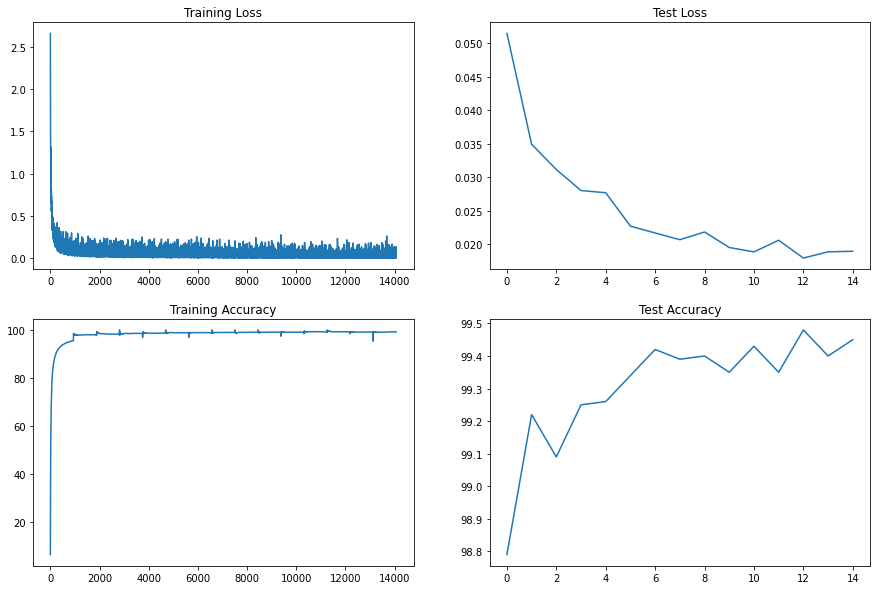

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

train_losses_cpu = []
for loss in train_losses:
    train_losses_cpu.append(loss.cpu().data.numpy())  

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")